In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/parkinson-disease-detection/Parkinsson disease.csv


In [2]:
# imports

import pandas as pd
import numpy as np
import os,sys

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix, confusion_matrix
from sklearn.metrics import classification_report


In [3]:
# models

classifiers = ['LinearSVM', 'RadialSVM', 
               'Logistic',  'RandomForest', 
               'AdaBoost',  'DecisionTree', 
               'KNeighbors','GradientBoosting']

models = [svm.SVC(kernel='linear'),
          svm.SVC(kernel='rbf'),
          LogisticRegression(max_iter = 1000),
          RandomForestClassifier(n_estimators=200, random_state=0),
          AdaBoostClassifier(random_state = 0),
          DecisionTreeClassifier(random_state=0),
          KNeighborsClassifier(),
          GradientBoostingClassifier(random_state=0)]

def split(df,label):
    X_tr, X_te, Y_tr, Y_te = train_test_split(df, label, test_size=0.25, random_state=42)
    return X_tr, X_te, Y_tr, Y_te

def acc_score(df,label):
    Score = pd.DataFrame({"Classifier":classifiers})
    j = 0
    acc = []
    X_train,X_test,Y_train,Y_test = split(df,label)
    for i in models:
        model = i
        model.fit(X_train,Y_train)
        predictions = model.predict(X_test)
        acc.append(accuracy_score(Y_test,predictions))
        j = j+1     
    Score["Accuracy"] = acc
    Score.sort_values(by="Accuracy", ascending=False,inplace = True)
    Score.reset_index(drop=True, inplace=True)
    return Score



In [4]:
df = pd.read_csv('../input/parkinson-disease-detection/Parkinsson disease.csv')
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


### Attribute Information:

Matrix column entries (attributes):  
name - ASCII subject name and recording number  
MDVP:Fo(Hz) - Average vocal fundamental frequency  
MDVP:Fhi(Hz) - Maximum vocal fundamental frequency  
MDVP:Flo(Hz) - Minimum vocal fundamental frequency  
MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP - Several
measures of variation in fundamental frequency  
MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA - Several measures of variation in amplitude  
NHR,HNR - Two measures of ratio of noise to tonal components in the voice
status - Health status of the subject (one) - Parkinson's, (zero) - healthy  
RPDE,D2 - Two nonlinear dynamical complexity measures  
DFA - Signal fractal scaling exponent  
spread1,spread2,PPE - Three nonlinear measures of fundamental frequency variation 

In [5]:
df.rename(columns=({'MDVP:Fo(Hz)':'avg_fre', 'MDVP:Fhi(Hz)':'max_fre', 'MDVP:Flo(Hz)':'min_fre', 'MDVP:Jitter(%)':'var_fre1',
       'MDVP:Jitter(Abs)':'var_fre2', 'MDVP:RAP':'var_fre3', 'MDVP:PPQ':'var_fre4', 'Jitter:DDP':'var_fre5',
       'MDVP:Shimmer':'var_amp1', 'MDVP:Shimmer(dB)':'var_amp2', 'Shimmer:APQ3':'var_amp3', 'Shimmer:APQ5':'var_amp4',
       'MDVP:APQ':'var_amp5', 'Shimmer:DDA':'var_amp6'}),inplace=True)
df.head(10)

,name,avg_fre,max_fre,min_fre,var_fre1,var_fre2,var_fre3,var_fre4,var_fre5,var_amp1,...,var_amp6,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335
5,phon_R01_S01_6,120.552,131.162,113.787,0.00968,0.00008,0.00463,0.00750,0.01388,0.04701,...,0.06985,0.01222,21.378,1,0.415564,0.825069,-4.242867,0.299111,2.187560,0.357775
6,phon_R01_S02_1,120.267,137.244,114.820,0.00333,0.00003,0.00155,0.00202,0.00466,0.01608,...,0.02337,0.00607,24.886,1,0.596040,0.764112,-5.634322,0.257682,1.854785,0.211756
7,phon_R01_S02_2,107.332,113.840,104.315,0.00290,0.00003,0.00144,0.00182,0.00431,0.01567,...,0.02487,0.00344,26.892,1,0.637420,0.763262,-6.167603,0.183721,2.064693,0.163755
8,phon_R01_S02_3,95.730,132.068,91.754,0.00551,0.00006,0.00293,0.00332,0.00880,0.02093,...,0.03218,0.01070,21.812,1,0.615551,0.773587,-5.498678,0.327769,2.322511,0.231571
9,phon_R01_S02_4,95.056,120.103,91.226,0.00532,0.00006,0.00268,0.00332,0.00803,0.02838,...,0.04324,0.01022,21.862,1,0.547037,0.798463,-5.011879,0.325996,2.432792,0.271362


In [6]:
df.status.describe()

count    195.000000
mean       0.753846
std        0.431878
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: status, dtype: float64

75% of the population are diagnosed with PD

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      195 non-null    object 
 1   avg_fre   195 non-null    float64
 2   max_fre   195 non-null    float64
 3   min_fre   195 non-null    float64
 4   var_fre1  195 non-null    float64
 5   var_fre2  195 non-null    float64
 6   var_fre3  195 non-null    float64
 7   var_fre4  195 non-null    float64
 8   var_fre5  195 non-null    float64
 9   var_amp1  195 non-null    float64
 10  var_amp2  195 non-null    float64
 11  var_amp3  195 non-null    float64
 12  var_amp4  195 non-null    float64
 13  var_amp5  195 non-null    float64
 14  var_amp6  195 non-null    float64
 15  NHR       195 non-null    float64
 16  HNR       195 non-null    float64
 17  status    195 non-null    int64  
 18  RPDE      195 non-null    float64
 19  DFA       195 non-null    float64
 20  spread1   195 non-null    float6

### Features engineering

In [8]:
df.duplicated().sum()

0

In [9]:
df.isnull().sum()

name        0
avg_fre     0
max_fre     0
min_fre     0
var_fre1    0
var_fre2    0
var_fre3    0
var_fre4    0
var_fre5    0
var_amp1    0
var_amp2    0
var_amp3    0
var_amp4    0
var_amp5    0
var_amp6    0
NHR         0
HNR         0
status      0
RPDE        0
DFA         0
spread1     0
spread2     0
D2          0
PPE         0
dtype: int64

In [10]:
df.notnull()

,name,avg_fre,max_fre,min_fre,var_fre1,var_fre2,var_fre3,var_fre4,var_fre5,var_amp1,...,var_amp6,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
191,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
192,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
193,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [11]:
df.drop(columns="name",axis=1,inplace=True)

In [12]:
x = df.loc[:,df.columns!='status'].values[:,:]
x1= df.loc[:,df.columns != 'status']
y = df.loc[:,'status'].values
y1= df.loc[:,'status']

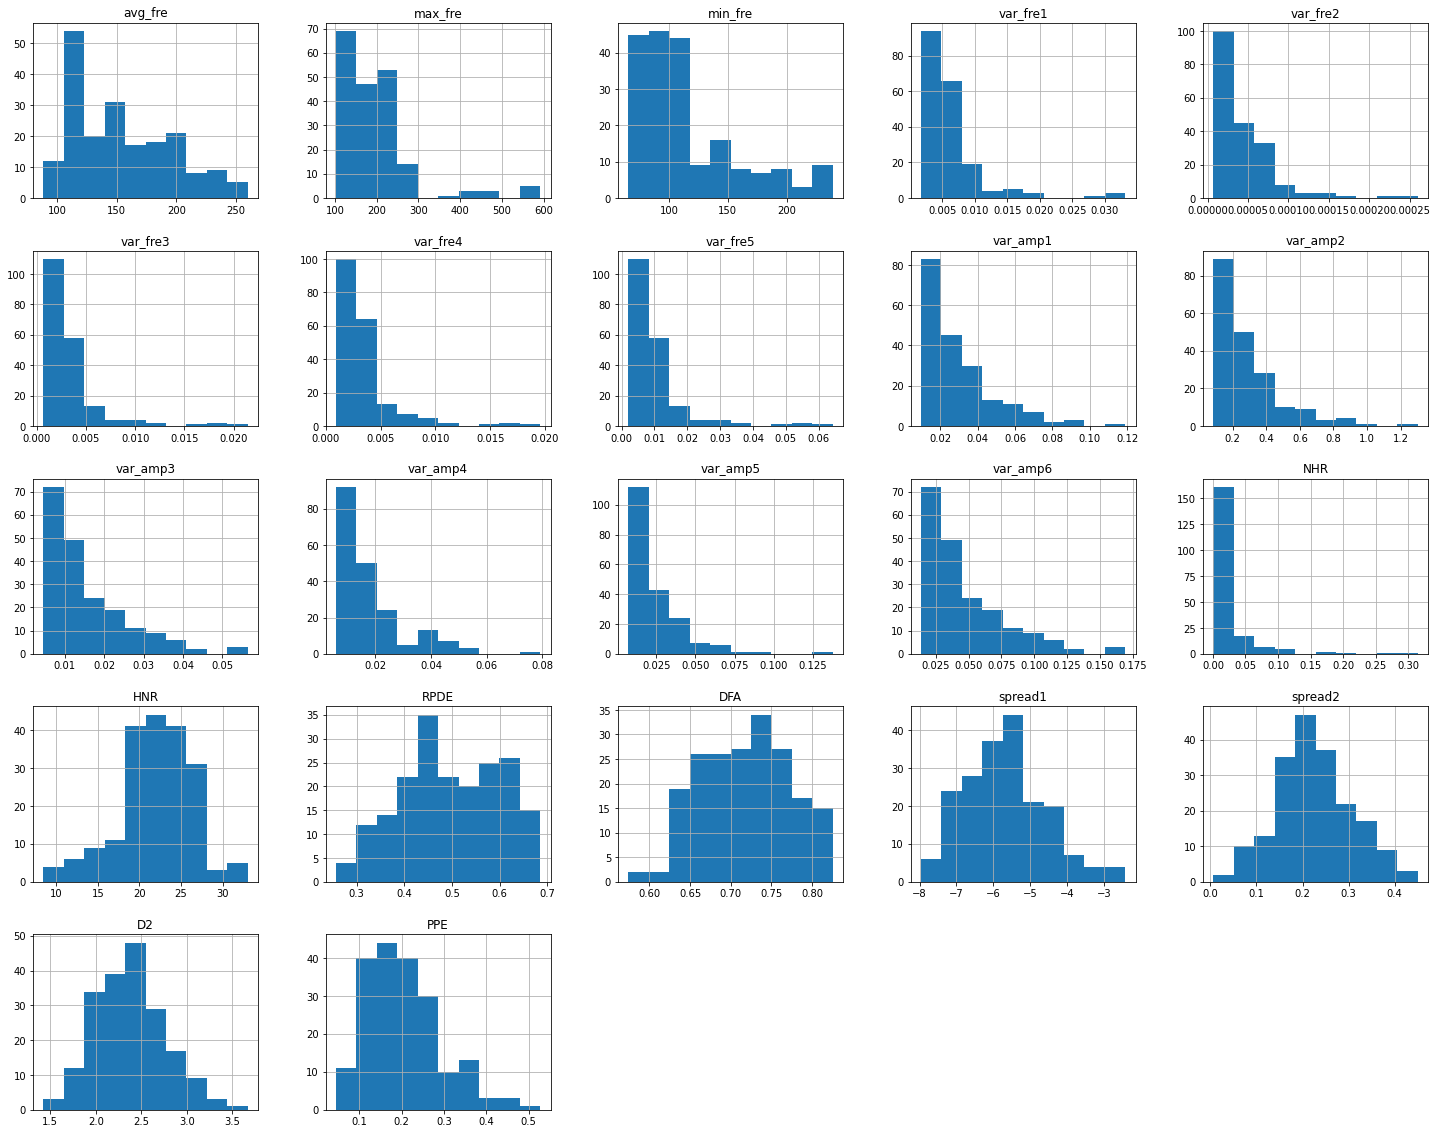

In [13]:
x1.hist(figsize=(25,20))
plt.show()

In [14]:
# deleting the skewness of the dataset

df = df[df.max_fre  <= 300]
df = df[df.var_fre1 <= 0.02]
df = df[df.var_fre2 <= 0.0001]
df = df[df.var_fre3 <= 0.01]
df = df[df.var_fre4 <= 0.01]
df = df[df.var_fre5 <= 0.04]
df = df[df.var_amp1 <= 0.10]
df = df[df.var_amp2 <= 1.0]
df = df[df.var_amp3 <= 0.04]
df = df[df.var_amp4 <= 0.050]
df = df[df.var_amp5 <= 0.075]
df = df[df.var_amp6 <= 0.125]
df = df[df.NHR      <= 0.15]

In [15]:
df.skew()

avg_fre     0.606810
max_fre     0.287746
min_fre     1.232084
var_fre1    1.089534
var_fre2    0.787568
var_fre3    1.159408
var_fre4    1.246280
var_fre5    1.158757
var_amp1    1.054773
var_amp2    1.135595
var_amp3    1.085616
var_amp4    1.358878
var_amp5    1.214514
var_amp6    1.085495
NHR         2.510519
HNR        -0.060831
status     -1.076186
RPDE       -0.073851
DFA        -0.142230
spread1     0.271689
spread2     0.145342
D2          0.478132
PPE         0.517074
dtype: float64

NHR gives a skewness of 2.5 which can be distrubing sometime -- Acceptable values of skewness fall between − 3 and + 3

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='NHR', ylabel='Density'>

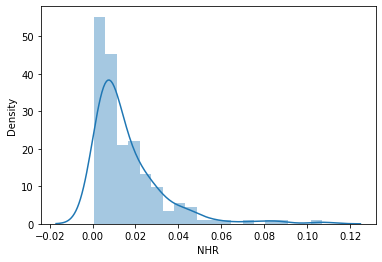

In [16]:
sns.distplot(df['NHR'])

In [17]:
df=df[df.NHR<=0.06]
df.skew()

avg_fre     0.629564
max_fre     0.328258
min_fre     1.245583
var_fre1    0.699469
var_fre2    0.769365
var_fre3    0.813203
var_fre4    1.212263
var_fre5    0.812495
var_amp1    1.063387
var_amp2    1.136743
var_amp3    1.116058
var_amp4    1.381370
var_amp5    1.098219
var_amp6    1.115979
NHR         1.327245
HNR         0.174386
status     -1.064996
RPDE       -0.061493
DFA        -0.133070
spread1     0.298066
spread2     0.123992
D2          0.194425
PPE         0.553609
dtype: float64

### Data Standardization 

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df = scaler.fit_transform(df)

### Correlation Matrix
Correlation is a statistical measure that expresses the strength of the relationship between two variables. The two main types of correlation are positive and negative. Positive correlation occurs when two variables move in the same direction; as one increases, so do the other. A negative correlation occurs when two variables move in opposite directions; as one increases, the other decreases

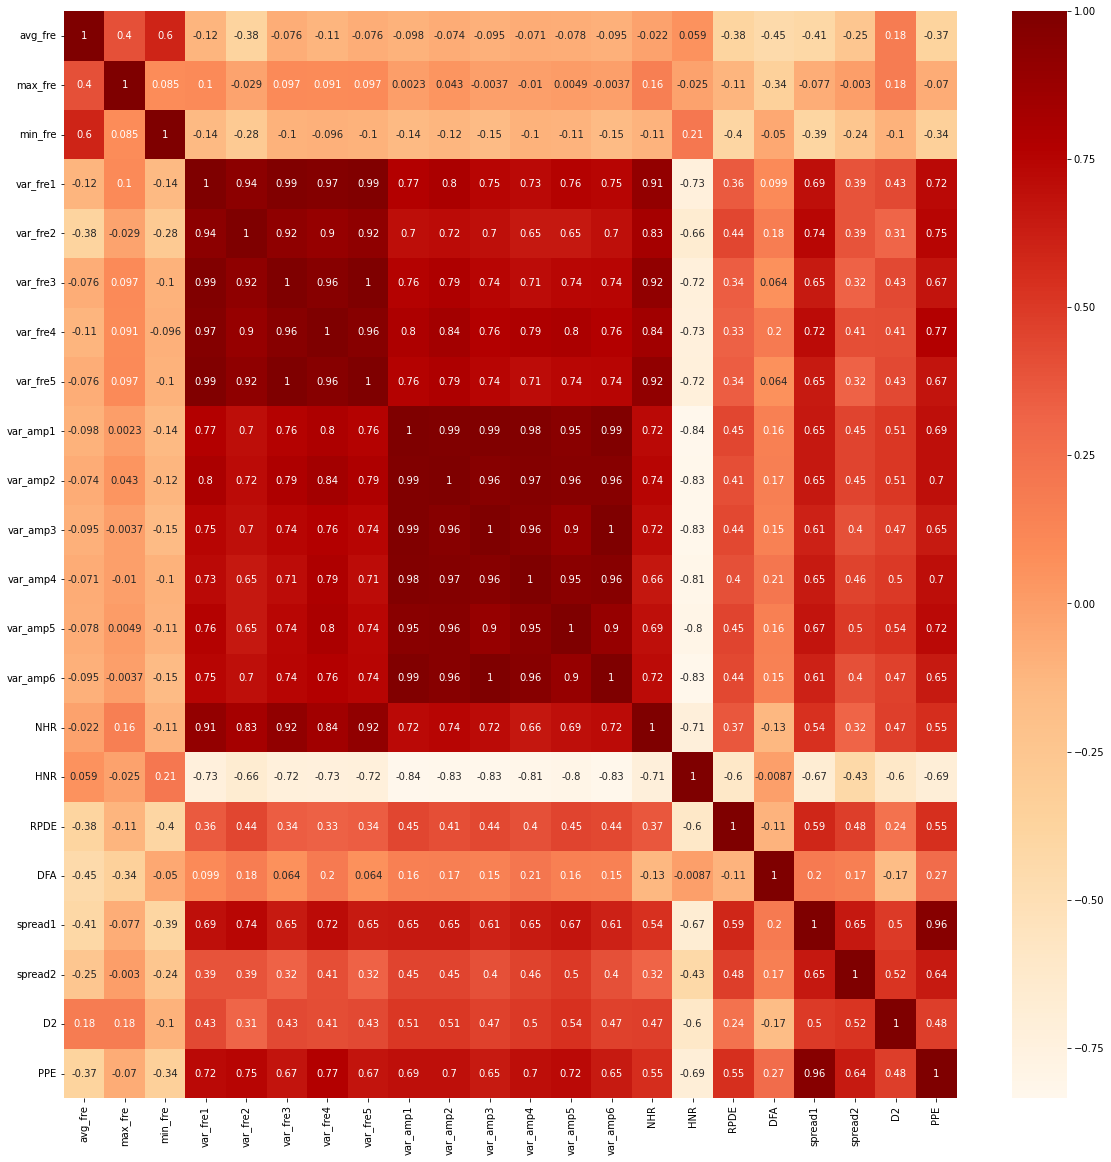

In [19]:
correl=x1.corr()
plt.figure(figsize=(20,20))
sns.heatmap(correl,annot=True,cmap='OrRd')
plt.show()

In [20]:
def correlation(dataset, cor):
    df = dataset.copy()
    col_corr = set()  # For storing unique value
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > cor: # absolute values to handle positive and negative correlations
                colname = corr_matrix.columns[i]  
                col_corr.add(colname)
    df.drop(col_corr,axis = 1,inplace = True)
    return df

def acc_score_cor(df,label,cor_list):
    Score = pd.DataFrame({"Classifier":classifiers})
    for k in range(len(cor_list)):
        df2 = correlation(df, cor_list[k])
        X_train,X_test,Y_train,Y_test = split(df2,label)
        j = 0
        acc = []
        for i in models:
            model = i
            model.fit(X_train,Y_train)
            predictions = model.predict(X_test)
            acc.append(accuracy_score(Y_test,predictions))
            j = j+1  
        feat = str(cor_list[k])
        Score[feat] = acc
    return Score

In [21]:
score = acc_score(x1,y1)
score

,Classifier,Accuracy
0,RandomForest,0.918367
1,Logistic,0.897959
2,GradientBoosting,0.897959
3,LinearSVM,0.877551
4,DecisionTree,0.877551
5,AdaBoost,0.857143
6,RadialSVM,0.836735
7,KNeighbors,0.836735


In [22]:
p = [0.5,0.6,0.7,0.8,0.9,0.95]
score_cor = acc_score_cor(x1, y1, p)
score_cor

,Classifier,0.5,0.6,0.7,0.8,0.9,0.95
0,LinearSVM,0.775510,0.816327,0.857143,0.877551,0.877551,0.877551
1,RadialSVM,0.857143,0.836735,0.836735,0.836735,0.836735,0.836735
2,Logistic,0.836735,0.816327,0.816327,0.897959,0.897959,0.897959
3,RandomForest,0.857143,0.836735,0.897959,0.918367,0.938776,0.918367
4,AdaBoost,0.857143,0.775510,0.816327,0.877551,0.877551,0.877551
5,DecisionTree,0.836735,0.836735,0.857143,0.795918,0.836735,0.836735
6,KNeighbors,0.897959,0.836735,0.836735,0.836735,0.836735,0.836735
7,GradientBoosting,0.836735,0.836735,0.897959,0.897959,0.918367,0.897959


### Visualization

In [23]:
def plot(df,l1,l2,p1,p2,c = "b"):
    feat = df.columns.tolist()
    feat = feat[1:]
    plt.figure(figsize = (16, 18))
    for j in range(0,df.shape[0]):
        value = []
        k = 0
        for i in range(1,len(df.columns.tolist())):
            value.append(df.iloc[j][i])
        plt.subplot(4, 4,j+1)
        ax = sns.pointplot(x=feat, y=value,color = c )
        plt.text(p1,p2,df.iloc[j][0])
        plt.xticks(rotation=90)
        ax.set(ylim=(l1,l2))
        k = k+1

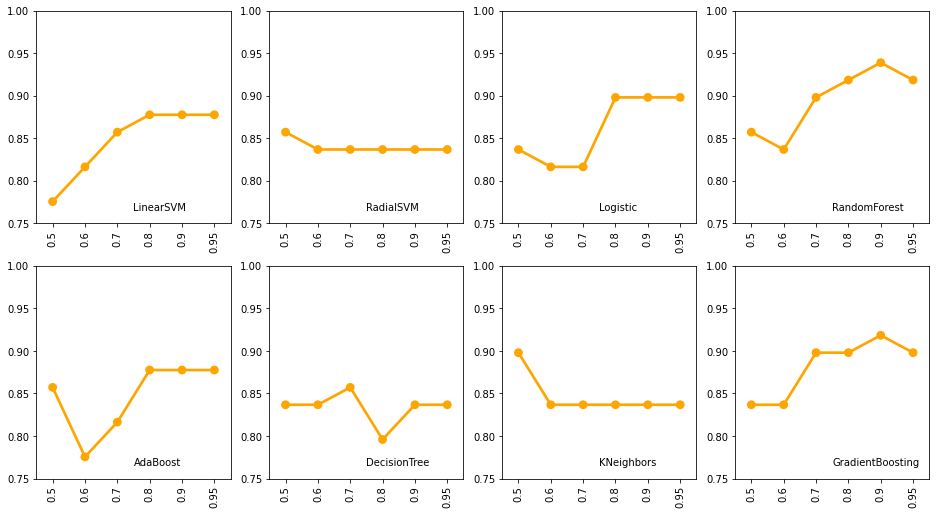

In [24]:
plot(score_cor,0.75,1,2.5,0.765,c = "orange")